In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import frame as fr
import algo_result as alg_res
import os
from sklearn import svm
from scipy.fft import fft, fftn, fftfreq, fftshift
from scipy.signal import spectrogram
%run algo_process.ipynb


In [2]:
SAMPLES_PER_CHIRP = 128
CHIRPS_PER_FRAME = 16
T = 300e-6
SPEED_OF_LIGHT = 3e8
START_FREQUENCY = 24.025e9
B = 200e6
PULSE_REPETITION_INTERVAL = 500e-6
SAMPLE_PERIOD = T/SAMPLES_PER_CHIRP
SAMPLE_FREQUENCY = 1/SAMPLE_PERIOD
LAMBDA = SPEED_OF_LIGHT/START_FREQUENCY
RANGE_PAD = 256
DOPPLER_PAD = 64
ANTENNA_SPACING = 6.22e-3

PEAK_THRESHOLD = 0.7 #FFT minimum strength
PEAK_SLICE = 2 #meters around target
PEAK_WIDTH = 1 #integer
PEAK_RELEVANCE = 0 #minimum distance between pvl1,pvr1 and pvc
SEARCH_ZONE = 40 #split spectrum in slices of 10 meters to find a single peak

ANGLE_CALIBRATION = -150
ANGLE_PRECISION = 1

ANTENNA_NUMBER = 2

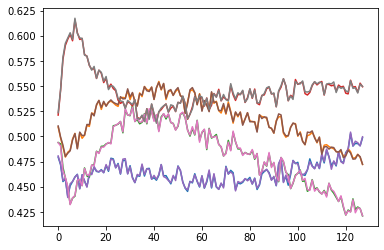

In [3]:
calibration_data = pd.read_csv('../Classification_data_KAUST/environment_test.txt', sep='\t', header=None)
calibration = calibration_data.select_dtypes(include = ['float']).values
calibration_frame = fr.Frame(calibration[0*CHIRPS_PER_FRAME*SAMPLES_PER_CHIRP:(0+1)*CHIRPS_PER_FRAME*SAMPLES_PER_CHIRP,:],\
                           SAMPLES_PER_CHIRP, CHIRPS_PER_FRAME, ANTENNA_NUMBER, T)

average_calib_chirp = np.zeros((SAMPLES_PER_CHIRP,ANTENNA_NUMBER),dtype=complex)
for chirp in range(CHIRPS_PER_FRAME):
    average_calib_chirp += calibration_frame.get_chirp(chirp)
average_calib_chirp /= CHIRPS_PER_FRAME
#averaged
plt.plot(np.real(average_calib_chirp))
plt.plot(np.imag(average_calib_chirp))
#non averaged
plt.plot(np.real(calibration_frame.chirp[:,:,0]))
plt.plot(np.imag(calibration_frame.chirp[:,:,0]))
plt.show()

../Classification_data_KAUST/biking_mixed_128_test_2.txt


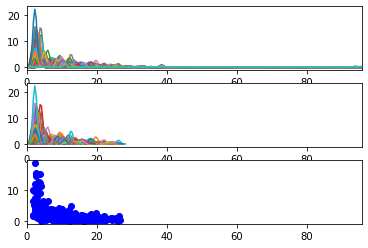

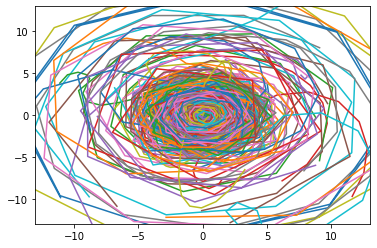

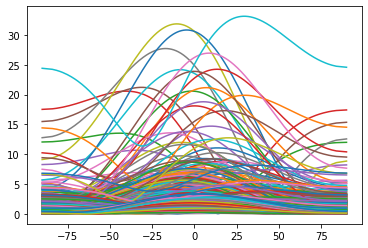

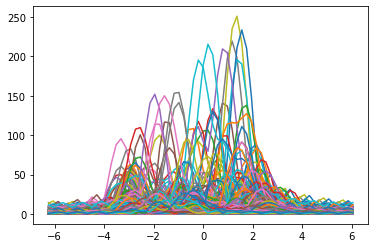

../Classification_data_KAUST/walking_mixed_128_test_2.txt


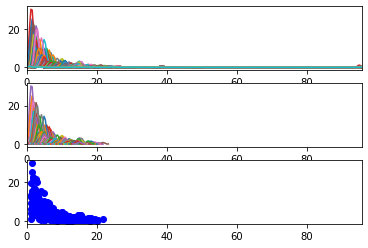

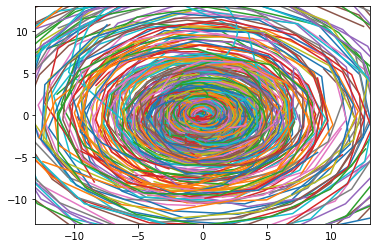

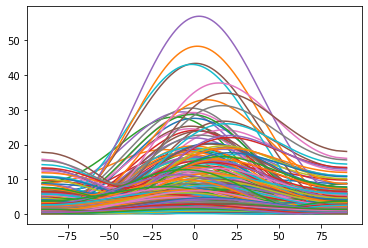

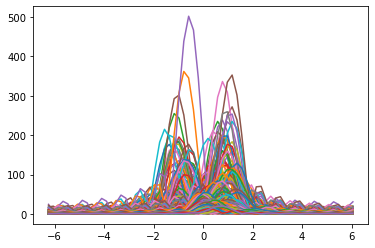

In [4]:
directory = os.fsencode('../Classification_data_KAUST/')
    
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename != 'Sky.txt' and filename.endswith('.txt') and (filename.startswith('biking_mixed') or filename.startswith('walking_mixed')):
        path = os.path.join(os.fsdecode(directory), filename)
        print(path)                    
        data = pd.read_csv(path, sep='\t', header=None)
        data.columns = ["idx","I_RX1","Q_RX1","I_RX2","Q_RX2"]
        
        recording = data.select_dtypes(include = ['float']).values
        FRAME_NUMBER = len(data)//(SAMPLES_PER_CHIRP*CHIRPS_PER_FRAME)
        Hu_bi_frame = []
        for frame in range(FRAME_NUMBER):
            Hu_bi_frame.append(fr.Frame(recording[frame*CHIRPS_PER_FRAME*SAMPLES_PER_CHIRP:(frame+1)*CHIRPS_PER_FRAME*SAMPLES_PER_CHIRP,:],\
                                   SAMPLES_PER_CHIRP, CHIRPS_PER_FRAME, ANTENNA_NUMBER, T)) 
       
        for frame in range(FRAME_NUMBER):
            Hu_bi_frame[frame].calibrate(average_calib_chirp)

        xf = np.arange(0,RANGE_PAD)
        range_bin = xf*T*SPEED_OF_LIGHT/(2*B)/(T/SAMPLES_PER_CHIRP)/RANGE_PAD
        range2bin = 1/(T/SAMPLES_PER_CHIRP)/RANGE_PAD*T*SPEED_OF_LIGHT/(2*B)
        vel_bin = fftshift(fftfreq(DOPPLER_PAD,PULSE_REPETITION_INTERVAL))*SPEED_OF_LIGHT/(2*START_FREQUENCY) 

        Target_observations = []
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
        ax1.set_xlim(range_bin[0],range_bin[-1])
        ax2.set_xlim(range_bin[0],range_bin[-1])
        ax3.set_xlim(range_bin[0],range_bin[-1])
        fig, ax4 = plt.subplots(1, 1)
        fig, ax5 = plt.subplots(1, 1)
        fig, ax6 = plt.subplots(1, 1)
        ax4.set_xlim(-13,13)
        ax4.set_ylim(-13,13)
        Target_info_list = []
        Target_presence_list = []
        for frame in range(FRAME_NUMBER):
            data_out,target_info = algo_process(Hu_bi_frame[frame],RANGE_PAD,CHIRPS_PER_FRAME,DOPPLER_PAD,PEAK_THRESHOLD,PEAK_SLICE,PEAK_WIDTH,PEAK_RELEVANCE,SEARCH_ZONE,ANGLE_CALIBRATION,ANGLE_PRECISION,round(LAMBDA/ANTENNA_SPACING),range2bin)
            if(target_info.num_targets > 0):
                Target_info_list.append(target_info)
                Target_presence_list.append(1)
            else:
                Target_presence_list.append(0)  
            ax1.plot(range_bin,np.abs((data_out[:,0,0].T)))
            for target in range(target_info.num_targets):
                if target_info.location[target] < SEARCH_ZONE:
                    ax3.plot(target_info.location[target], target_info.strength[target],'bo')
                    ax2.plot(target_info.print_location[:,target],target_info.print[:,0,target])
                    ax4.plot(np.real(target_info.doppler_mark[:,target]),np.imag(target_info.doppler_mark[:,target]))
                    ax5.plot(target_info.angle,target_info.angle_spectrum[:,target])
                    ax6.plot(vel_bin,target_info.doppler_spectrum[:,target])
                    for chirp_num in range(CHIRPS_PER_FRAME):
                        Target_observations.append(np.append(target_info.print[:,chirp_num,target],target_info.location[target]))
                elif target_info.location[target] > SEARCH_ZONE:
                    ax3.plot(target_info.print_location[:,target],target_info.print[:,target])
        
        plt.show()
        df = pd.DataFrame(Target_observations).T
        output_path = "../data_out/"
        
        output_filename = filename.split('.')[0]+'_out'
        extension = '_single_chirps.txt'
        df.T.to_csv(output_path+output_filename+extension, sep='\t',index=False, header=False) 

In [5]:
plt.plot(target_info.print[:,:,0])

IndexError: index 0 is out of bounds for axis 2 with size 0

In [ ]:
target_info.print[:,:,0].T

In [ ]:
plt.plot(np.real(target_info.doppler_mark[:,target]))